In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [2]:
def gaussian_kernel(X, krnl_sigma=0.5): # too low values return nan loss
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = torch.exp(-dists_sq / (2 * (krnl_sigma**2))) / (math.sqrt(2 * math.pi * krnl_sigma**2))
    return K

# def rbf(x):
#         x = x - x.T
#         return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

def rbf(X, krnl_sigma=0.1):
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = torch.exp(-dists_sq / (2 * (krnl_sigma**2)))
    return K

# def cauchy(x):
#         x = x - x.T
#         return  1. / (krnl_sigma*(x**2) + 1)
    
def cauchy(X, krnl_sigma=0.1):
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = 1. / (krnl_sigma * dists_sq + 1)
    return K


In [3]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [4]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [5]:
input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat_1 = 1024
hidden_dim_feat_2 = 512
hidden_dim_target_1 = 24
hidden_dim_target_2 = 8
output_dim = 2
num_epochs = 1000




In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim)

In [7]:
temperature = 0.02
base_temperature = 0.02  # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 5 # too low values return nan loss
n_splits = 5

In [8]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [9]:
results_cv = []
best_mae = np.inf
best_r2 = -np.inf
best_average_loss = np.inf
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting fold {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)
    
    model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat_1, hidden_dim_feat_2, hidden_dim_target_1, hidden_dim_target_2, output_dim).to(device)
    criterion = KernelizedSupCon(method='expw', temperature = temperature, base_temperature = base_temperature, kernel=kernel)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Fold {fold} | Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
            
    val_losses = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for features, targets in val_loader:
            features = features.to(device).float()
            targets = targets.to(device)

            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            val_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)
        val_losses =np.array(val_losses)
        average_loss = total_loss / total_samples
#         if best_average_loss > average_loss:
#             best_average_loss = average_loss
#             save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
    r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
    if mape_train < best_mae and r2_train > best_r2: # saving the one which has the best train metrics
        best_mape = mape_train
        best_r2 = r2_train
        save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    results_cv.append([fold, mape_train, r2_train, mape_val, r2_val])

    

Starting fold 0
Fold 0 | Epoch 0 | Mean Loss 3.2488508789162887


KeyboardInterrupt: 

In [74]:
results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [10]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat_1, hidden_dim_feat_2, hidden_dim_target_1, hidden_dim_target_2, output_dim)
model.load_state_dict(torch.load('best_model_hopkins_cv.pt')["model"])
criterion = KernelizedSupCon(method='expw', temperature = temperature, base_temperature = base_temperature, kernel=kernel)
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('best_model_hopkins_cv.pt')["optimizer"])

In [12]:
torch.load('best_model_hopkins_cv.pt')["cv_fold"]

0

In [13]:
model.to(device)

MLP(
  (feat_mlp): Sequential(
    (0): Linear(in_features=499500, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
  (target_mlp): Sequential(
    (0): Linear(in_features=59, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [15]:
test_losses = []
model.eval()
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   1.36


In [16]:
emb_features = np.row_stack(emb_features)

In [17]:
emb_targets = np.row_stack(emb_targets)

In [18]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [19]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [20]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'
embeddings = pd.concat([emb_features, emb_targets])

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

<Axes: xlabel='Dim_1', ylabel='Dim_2'>

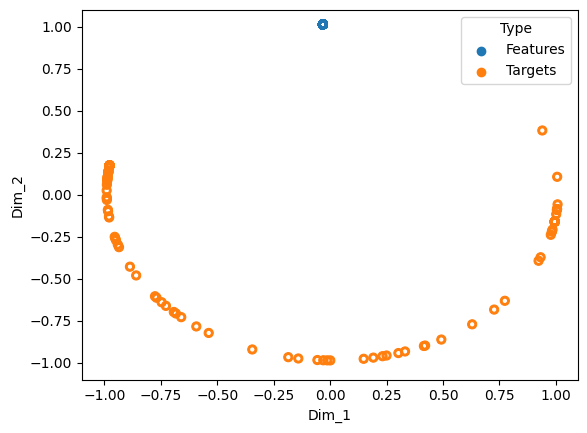

In [21]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
sns.scatterplot(embeddings, x = 'Dim_1', y = 'Dim_2', hue = 'Type', marker="$\circ$", ec="face", s = 100)


In [22]:
embeddings[embeddings['sub'] == 1]

,Dim_1,Dim_2,sub,Type
0,-0.042145,0.999112,1,Features
0,-0.987198,0.159500,1,Targets


In [24]:
mae_train, mae_test = compute_target_score(model, train_loader, test_loader, device, 'mape')
r2_train, r2_test = compute_target_score(model, train_loader, test_loader, device, 'r2')

print(f"Train MAPE: {mae_train}, Test MAPE: {mae_test}.")
print(f"Train R2: {r2_train}, Test R2: {r2_test}.")

Training target estimator
Training target estimator
Train MAPE: 1.5097272396087646, Test MAPE: 1.603095293045044.
Train R2: 6.000279517137663e-07, Test R2: -0.048680421194799206.


## Learning curve

In [25]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, train_loader, device)
X_test, y_test = gather_feats_targets(model, test_loader, device)


In [26]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [27]:
estimator = TargetEstimator()

In [28]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


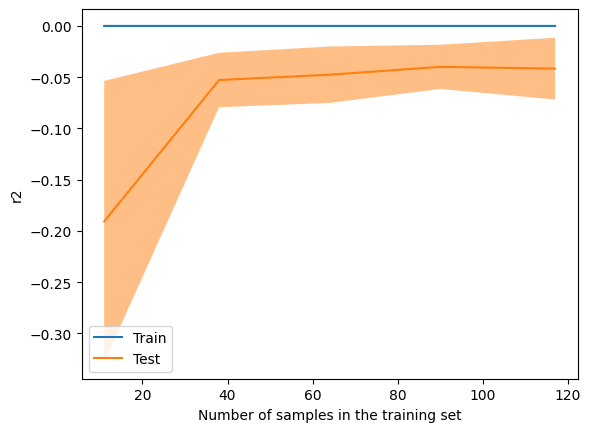

In [29]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
